In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

In [ ]:
# compare histogram of pixel avg for train vs adversarial

In [3]:
train_data_path = 'DEEPSAT6/X_train_sat6.csv'
train_label_path = 'DEEPSAT6/y_train_sat6.csv'
test_data_path = 'DEEPSAT6/X_test_sat6.csv'
test_label_path = 'DEEPSAT6/y_test_sat6.csv'

In [4]:
x_train = pd.read_csv(train_data_path, header=None, dtype='uint8')
y_train = pd.read_csv(train_label_path, header=None, dtype='uint8')
x_test = pd.read_csv(test_data_path, header=None, dtype='uint8')
y_test = pd.read_csv(test_label_path, header=None, dtype='uint8')

In [5]:
print("Train data shape: ", x_train.shape)
print("Train label shape: ", y_train.shape)
print("Test data shape: ", x_test.shape)
print("Test label shape: ", y_test.shape)

Train data shape:  (324000, 3136)
Train label shape:  (324000, 6)
Test data shape:  (81000, 3136)
Test label shape:  (81000, 6)


In [6]:
x_train = x_train.values.reshape([-1,28,28,4])
x_test = x_test.values.reshape([-1,28,28,4])

x_train.shape, x_test.shape

((324000, 28, 28, 4), (81000, 28, 28, 4))

In [7]:
class_names = ['Construction', 'Road', 'Grassland', 'Barren', 'Water', 'Treecover']
class_count = len(class_names)

print("Num. classes: %d" % class_count)
print("Class names:", class_names)

Num. classes: 6
Class names: ['Construction', 'Road', 'Grassland', 'Barren', 'Water', 'Treecover']


In [8]:
def label_converter(values):
  if values[0] == 1:    # Building 
    return 0
  elif values[1] == 1:  # Barren land 
    return 3
  elif values[2] == 1:  # Trees
    return 5
  elif values[3] == 1:  # Grassland
    return 2
  elif values[4] == 1:  # Road
    return 1
  elif values[5] == 1:  # Water
    return 4
  else:
    return None

In [9]:
y_train = y_train.apply(label_converter, axis=1).values.ravel().astype('uint8')
#y_train = train_label.values.ravel().astype('uint8')
#y_train = train_label.apply(label_converter, axis=1).astype('category')
y_train

array([5, 3, 4, ..., 4, 2, 3], dtype=uint8)

In [10]:
y_test = y_test.apply(label_converter, axis=1).values.ravel().astype('uint8')
#y_test = test_label.values.ravel().astype('uint8')
#y_test = test_label.apply(label_converter, axis=1).astype('category')
y_test

array([5, 5, 4, ..., 5, 4, 5], dtype=uint8)

In [11]:
np.unique(y_train, return_counts=True)
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=uint8),
 array([ 3714,  2070, 12596, 18367, 30068, 14185], dtype=int64))

In [12]:
def show_samples(data, labels):
    fig = plt.figure(figsize=(16, 8))
    ax = []
    rows, columns = 4, 8
    
    for i in range(columns * rows):
        index = np.random.randint(1, 500)
        img = data[index].reshape([28,28,4])[:,:,:3]
        class_name = class_names[labels[index]]
        ax.append(fig.add_subplot(rows, columns, i+1))
        ax[-1].set_title(class_name)
        plt.axis("off")
        plt.imshow(img)

    plt.subplots_adjust(wspace=0.1, hspace=0.5)
    plt.show()

In [13]:
# show_samples(x_train, y_train) <---- BROKEN with dtype tf.float32

In [14]:
def show_sample_histogram(data, labels, index=None):

    if not index:
        index = np.random.randint(1, len(labels))

    fig = plt.figure(figsize=(12, 6))
    ax = []
    rows, columns = 1, 2
    colors = ("red", "green", "blue", "purple")
    channel_ids = (0, 1, 2, 3)

    all = data[index].reshape([28, 28, 4])

    class_name = class_names[labels[index]]
    rgb = all[:,:,:3]
    ax.append(fig.add_subplot(rows, columns, 1))
    ax[-1].set_title(class_name, fontsize=20)
    plt.axis("off")
    plt.imshow(rgb)

    ax.append(fig.add_subplot(rows, columns, 2))
    ax[-1].set_xlim([0, 256])
    for channel_id, c in zip(channel_ids, colors):
        histogram, bin_edges = np.histogram(
            all[:, :, channel_id], bins=256, range=(0, 256))
        ax[-1].plot(bin_edges[0:-1], histogram, color=c, linewidth=0.8)
        ax[-1].set_title('Histogram of pixels', fontsize=20)
        ax[-1].legend(['R', 'G', 'B', 'NIR'])

    fig.tight_layout()

    #plt.subplots_adjust(wspace=0.1, hspace=0.5)
    plt.show()

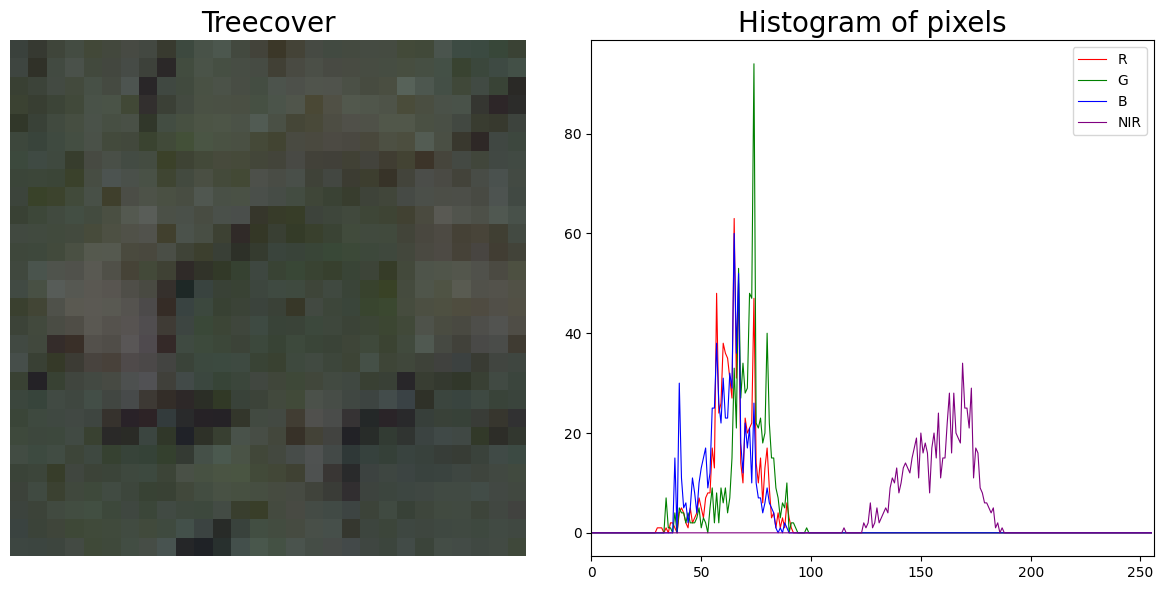

In [15]:
show_sample_histogram(x_train, y_train) #index = n

In [16]:
x_train_partial, x_validation, y_train_partial, y_validation = train_test_split(
    x_train, y_train, test_size=0.3, random_state=0, stratify=y_train)

print(x_train_partial.shape)
print(x_validation.shape)
print(y_train_partial.shape)
print(y_validation.shape)

(226800, 28, 28, 4)
(97200, 28, 28, 4)
(226800,)
(97200,)


In [17]:
def train_and_test(id, model, x_train, y_train, x_test, y_test, epochs=10): 
    global best_model, best_accuracy

    start_time = datetime.now()
    model.fit(x_train, y_train, epochs=epochs)

    end_time = datetime.now()
    duration = (end_time - start_time).total_seconds()

    print("Training took %.1f seconds" % duration)
    
    print(f"Model eval:")
    accuracy = model.evaluate(x_test, y_test)

    #benchmark[id] = (accuracy[1], accuracy[0], duration)

    #if accuracy[1] > best_accuracy:
    #    best_model = model
    #    best_accuracy = accuracy[1]

    return accuracy

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [ ]:
def create_modelv1(class_count, print_summary=False):

    model = Sequential([
        Conv2D(32, (4,4), activation='relu', input_shape=(28,28,4)),
        MaxPool2D((3,3)),
        Flatten(),
        Dense(class_count, activation='softmax'),
    ])

    model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    if print_summary:
        model.summary()

    return model

In [20]:
seed_value = 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

In [37]:
epsilon=0.1
x_test_lim = x_test[:500]
y_test_lim = y_test[:500]
x_train_lim = x_train[:500]
y_train_lim = y_train[:500]

In [55]:
modelv1 = create_modelv1(class_count)
train_and_test('v0.1', modelv1, x_train_lim, y_train_lim, x_test_lim, y_test_lim, epochs=3)

Epoch 1/3


c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\asyncio\base_events.py", line 641, in run_forever

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\asyncio\base_events.py", line 1986, in _run_once

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\asyncio\events.py", line 88, in _run

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\Durf\AppData\Local\Temp\ipykernel_13836\427456917.py", line 2, in <module>

  File "C:\Users\Durf\AppData\Local\Temp\ipykernel_13836\718563703.py", line 5, in train_and_test

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 320, in fit

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 54, in train_step

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\keras\src\trainers\trainer.py", line 359, in _compute_loss

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\keras\src\trainers\trainer.py", line 327, in compute_loss

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\keras\src\trainers\compile_utils.py", line 611, in __call__

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\keras\src\trainers\compile_utils.py", line 652, in call

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\keras\src\losses\loss.py", line 60, in __call__

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\keras\src\losses\losses.py", line 27, in call

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\keras\src\losses\losses.py", line 1870, in sparse_categorical_crossentropy

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\keras\src\ops\nn.py", line 1559, in sparse_categorical_crossentropy

  File "c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 671, in sparse_categorical_crossentropy

Received a label value of 5 which is outside the valid range of [0, 1).  Label values: 4 4 3 5 3 4 5 4 3 2 5 3 3 4 5 3 4 4 4 2 4 2 3 4 4 3 5 3 4 4 0 4
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_one_step_on_iterator_424834]

In [51]:
modelv1.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │        12,294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,124 (168.46 KB)

 Trainable params: 14,374 (56.15 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 28,750 (112.31 KB)

In [47]:
def fgsm_attack(model, images, labels, epsilon):
    # Enable gradient tape for automatic differentiation
    with tf.GradientTape() as tape:
        # Cast images to float32 if they are not already
        images = tf.convert_to_tensor(images, dtype=tf.float32)
        # Make the model predictions
        predictions = model(images)
        print(predictions)
        # Calculate the loss
        loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)

    # Calculate gradients of the loss with respect to the input image
    gradients = tape.gradient(loss, images)
    print(gradients)
    # Get the sign of the gradients
    signed_gradients = tf.sign(gradients)
    # Create the adversarial images
    adversarial_images = images + epsilon * signed_gradients
    # Clip the values to maintain valid pixel range
    adversarial_images = tf.clip_by_value(adversarial_images, 0, 1)  # Adjust based on normalization

    return adversarial_images

In [48]:
adversarial_images = fgsm_attack(modelv1, x_test_lim, y_test_lim, epsilon)

tf.Tensor(
[[1.8476115e-33 7.8205321e-27 4.7568426e-02 1.3972004e-26 1.8491847e-32
  9.5243162e-01]
 [8.6143991e-06 4.6932920e-14 8.0100773e-04 3.6720763e-15 1.1854995e-24
  9.9919039e-01]
 [1.8499763e-16 4.2252998e-29 0.0000000e+00 0.0000000e+00 1.0000000e+00
  0.0000000e+00]
 ...
 [3.5645144e-07 6.3802436e-06 1.7667354e-10 9.9999321e-01 0.0000000e+00
  9.1771828e-25]
 [3.8566155e-20 6.5624002e-28 0.0000000e+00 0.0000000e+00 1.0000000e+00
  0.0000000e+00]
 [4.0496515e-33 8.5428817e-33 1.0947020e-20 2.4300464e-35 0.0000000e+00
  1.0000000e+00]], shape=(500, 6), dtype=float32)
None


ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [ ]:
loss,accuracy = modelv1.evaluate(adversarial_images, y_train)
print(f"Adversarial acc: {accuracy}")

In [ ]:
# # Custom training loop
# for epoch in range(num_epochs):
#     for images, labels in train_dataset:  # Assuming you have a training dataset
#         # Generate adversarial examples
#         adversarial_images = fgsm_attack(model, images, labels, epsilon)

#         # Combine clean and adversarial images for training (if desired)
#         combined_images = tf.concat([images, adversarial_images], axis=0)
#         combined_labels = tf.concat([labels, labels], axis=0)  # Repeat labels

#         # Train the model
#         model.train_on_batch(combined_images, combined_labels)